Sheet 7.1: Using pretrained LLMs w/ the 'transformers' package
==============================================================





The &rsquo;transformers&rsquo; package by [huggingface](https://huggingface.co/) provides direct access to a multitude of pretrained large language models (LLMs).
Models and easy-to-use pipelines for many common NLP-tasks exist, ranging from (causal or masked) language modeling over machine translation to sentiment analysis or natural language inference.
This brief tutorial showcases how to download a pre-trained causal LLM, a version of OpenAI&rsquo;s GTP-2, how to use it for generation, and how to access its predictions (next-word probabilities, sequence embeddings).

The &rsquo;transformers&rsquo; package provides models for use with several programming environments, including Tensorflow, Rust or Jax.
Not all models or tools are available for all programming environments, but PyTorch and Tensorflow are covered best.



## Packages



We will make heavy use of the &rsquo;transformers&rsquo; package, but also use huggingface&rsquo;s &rsquo;datasets&rsquo; package to access a data set of text from Wikipedia articles.
In particular, we import two modules from the &rsquo;transformers&rsquo; package which give us access to instances of OpenAI&rsquo;s GPT-2 model for causal language modeling.
We need &rsquo;torch&rsquo; for tensor manipulations and &rsquo;textwrap&rsquo; to prettify output.



In [1]:
!!pip install datasets
!pip install fsspec==2024.10.0
!pip install --force-reinstall gcsfs

  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.2.0 requires fsspec[http]<=2024.9.0,>=2023.1.0, but you have fsspec 2024.10.0 which is incompatible.
  Using cached gcsfs-2024.10.0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached aiohttp-3.11.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached decorator-5.1.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
  Using cached google_auth-2.36.0-py2.py3-none-any.whl.metadata (4.7 kB)
  Using cached google_auth_oauthlib-1.2.1-py2.p

In [2]:
##################################################
## import packages
##################################################

from transformers import GPT2TokenizerFast, GPT2LMHeadModel
from datasets import load_dataset
import torch
import textwrap
import warnings
warnings.filterwarnings('ignore')

## Helpers



Here is a small helper function for prettier (?) printing of generated output text:



In [3]:
##################################################
## helper function (nicer printing)
##################################################

def pretty_print(s):
    print("Output:\n" + 80 * '-')
    print(textwrap.fill(tokenizer.decode(s, skip_special_tokens=True),80))

## Obtaining a pretrained LLM



The &rsquo;transformers&rsquo; package provides access to many different (language) models (see [here](https://huggingface.co/models) for overview).
One of them is GPT-2.
There are several types of GPT-2 instances we can instantiate through the &rsquo;transformers&rsquo; package, be it for different architectures (PyTorch, Tensorflow etc) or for different purposes (sequence classification, language modeling etc).
Here is [overview of the GPT-2 model family](https://huggingface.co/docs/transformers/v4.25.1/en/model_doc/gpt2).

In this tutorial, we are interested in using GPT-2 for (left-to-right) language modeling.
We therefore use the module &rsquo;[GPT2LMHeadModel](https://huggingface.co/docs/transformers/v4.25.1/en/model_doc/gpt2#transformers.GPT2LMHeadModel)&rsquo;.
This module provides access to different variants of GPT-2 models (larger or smaller, trained on more or less text).
Here we use the &rsquo;gpt2-large&rsquo; instance, just because.

Since different (language) models also use different tokenization, we also use the corresponding tokenizer from the module &rsquo;GPT2TokenizerFast&rsquo;.



In [4]:
##################################################
## instantiating LLM & its tokenizer
##################################################

# model_to_use = "gpt2"
model_to_use = "gpt2-large"

print("Using model: ", model_to_use)

# get the tokenizer for the pre-trained LM you would like to use
tokenizer = GPT2TokenizerFast.from_pretrained(model_to_use)

# instantiate a model (causal LM)
model = GPT2LMHeadModel.from_pretrained(model_to_use,
                                        output_scores=True,
                                        pad_token_id=tokenizer.eos_token_id)

# inspecting the (default) model configuration
# (it is possible to created models with different configurations)
print(model.config)

Using model:  gpt2-large


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "gpt2-large",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1280,
  "n_head": 20,
  "n_inner": null,
  "n_layer": 36,
  "n_positions": 1024,
  "output_scores": true,
  "pad_token_id": 50256,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.46.3",
  "use_cache": true,
  "vocab_size": 50257
}



## Using the LLM for text generation



The instance of the pre-trained LLM, which is now accessible with variable &rsquo;model&rsquo;, comes with several functions for use to use, one of which is &rsquo;generate&rsquo;.
We can use it to generate text after an initial prompt.
First, the input prompt must be translated into tokens, then fed into &rsquo;generate&rsquo;, which takes arguments to specify the decoding strategy (here top-k sampling).
The output is a tensor of tokens, which must be translated back into human-intelligible words for output.



In [9]:
##################################################
## autoregressive generation
##################################################

# text to expand
prompt = "Once a vampire fell in love with a pixie so that they"

# translate the prompt into tokens
input_tokens = tokenizer(prompt, return_tensors="pt").input_ids
print(input_tokens)

outputs = model.generate(input_tokens,
                         max_new_tokens=100,
                         do_sample=True,
                         top_k=50,
                       )

print("\nTop-k sampling:\n")


tensor([[ 7454,   257, 23952,  3214,   287,  1842,   351,   257,   279, 39291,
           523,   326,   484]])

Top-k sampling:



We can also use beam search through &rsquo;generate&rsquo; by setting the parameter &rsquo;num<sub>beams</sub>&rsquo;.



In [11]:
outputs = model.generate(input_tokens,
                         max_new_tokens=100,
                         num_beams=6,
                         no_repeat_ngram_size=4,
                         early_stopping=True
                         )

print("\nBeam search:\n")



Beam search:



## Accessing next-word probabilities



To access the model&rsquo;s (raw) predictions, which are (log) next-word probabilities, we can just call the function &rsquo;model&rsquo; itself, which gives us access to the forward-pass of the model.
We simply need to feed in a prompt sequence as input.
We can additionally feed in a sequence of tokens as &rsquo;labels&rsquo; for which we then obtain the predicted next-word probabilities.
NB: The $i$-th word in the sequence of labels is assigned the probability obtained after having processed all words up to and including the $i$-th word of the input-token sequence.

The average negative log-likelihood of the provided labels is accessed through the &rsquo;loss&rsquo; attribute of the returned object from a call to &rsquo;model&rsquo;.
The returned object is of type &rsquo;[CausalLMOutputWithCrossAttentions](https://huggingface.co/docs/transformers/main/en/main_classes/output#transformers.modeling_outputs.CausalLMOutputWithCrossAttentions)&rsquo;.



In [12]:
##################################################
## retrieving next-word surprisals from GPT-2
##################################################

# NB: we can supply tensors of labels (token ids for next-words, no need to right-shift)
# using -100 in the labels means: "don't compute this one"
labels        = torch.clone(input_tokens)
labels[0,0]   = -100
output_word2  = model(input_tokens[:,0:2], labels= labels[:,0:2])
output_prompt = model(input_tokens, labels=input_tokens)

# negative log-likelihood of provided labels
nll_word2  = output_word2.loss
nll_output = output_prompt.loss * input_tokens.size(1)
print("NLL of second word: ", nll_word2.item())
print("NLL of whole output:", nll_output.item())

NLL of second word:  3.040788173675537
NLL of whole output: 51.0084114074707


We can also retrieve the logits (= non-normalized weights prior to the final softmax operation) from the returned object, and so derive the next-word probabilities:



In [13]:
# logits of provided labels
print(output_word2.logits)
# next-word log probabilities:
print(torch.nn.functional.log_softmax(output_word2.logits, dim = 1))

tensor([[[ 2.3684,  0.9006, -4.1059,  ..., -6.9914, -4.4546,  0.0598],
         [-0.9339,  0.0542, -3.9052,  ..., -6.6439, -4.8402, -1.2681]]],
       grad_fn=<UnsafeViewBackward0>)
tensor([[[-0.0361, -0.3569, -0.7985,  ..., -0.8819, -0.5188, -0.2351],
         [-3.3384, -1.2034, -0.5978,  ..., -0.5344, -0.9044, -1.5630]]],
       grad_fn=<LogSoftmaxBackward0>)


## Accessing the embeddings (hidden states)



If we want to repurpose the LLM, we would be interested in the embedding of an input sequence, i.e., the state of the final hidden layer after an input sequence.
Here is how to access it:



In [14]:
##################################################
## retrieving sequence embedding
##################################################

# set flag 'output_hidden_states' to true
output = model(input_tokens, output_hidden_states = True)

# this is a tuple with first element the embeddings of each token in the input
hidden_states = output.hidden_states
# so, access the first object from the tuple
embeddings = hidden_states[0]
# and print its size and content
print(embeddings.size())
print("Embedding of last word in input:\n", embeddings[0,0-1])

torch.Size([1, 13, 1280])
Embedding of last word in input:
 tensor([ 0.0360,  0.0201, -0.0314,  ...,  0.0598,  0.0014, -0.0129],
       grad_fn=<SelectBackward0>)


## [Excursion:] Using data from &rsquo;datasets&rsquo;



The &rsquo;transformers&rsquo; package is accompanied by the &rsquo;datasets&rsquo; package (also from huggingface), which includes a bunch of interesting data sets for further exploration or fine-tuning.

Here is a brief example of how to load a data set of text from Wikipedia, which we need to pre-process a bit (conjoin lines, tokenize) and then feed into the LLM to access the average negative log-likelihood of the sequence.



In [15]:
##################################################
## working with datasets
##################################################

test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

input_tokens = encodings.input_ids[:,10:50]

pretty_print(input_tokens[0])

output = model(input_tokens, labels = input_tokens)
print("Average NLL for wikipedia chunk", output.loss.item())

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (287644 > 1024). Running this sequence through the model will result in indexing errors


Output:
--------------------------------------------------------------------------------
  Robert Boulter is an English film , television and theatre actor . He had a
guest @-@ starring role on the television series The Bill in 2000 . This was
followed by a starring role
Average NLL for wikipedia chunk 3.621718168258667


In [19]:
# Import necessary libraries
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split

# Load the dataset (replace with your dataset)
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

# Set a padding token for the tokenizer
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Tokenize the dataset
texts = dataset["text"]
tokenized_texts = tokenizer("\n\n".join(texts), return_tensors="pt", truncation=True, padding=True)

# Prepare input-output pairs for next-word prediction
seq_length = 50  # Define sequence length
input_ids = tokenized_texts["input_ids"][0]

X, y = [], []
for i in range(seq_length, len(input_ids)):
    X.append(input_ids[i-seq_length:i])  # Previous tokens
    y.append(input_ids[i])  # Target token (next word)


# Convert sequences to tensors and pad them
X_train = pad_sequence([torch.tensor(seq) for seq in X_train], batch_first=True, padding_value=tokenizer.pad_token_id)
X_val = pad_sequence([torch.tensor(seq) for seq in X_val], batch_first=True, padding_value=tokenizer.pad_token_id)
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)



In [20]:
# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 3
batch_size = 32
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    model.train()
    epoch_loss, correct, total = 0, 0, 0

    # Training step
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        outputs = model(batch_X, labels=batch_X)
        loss = outputs.loss
        logits = outputs.logits[:, -1, :]  # Logits of the last token
        predictions = logits.argmax(dim=-1)

        # Accuracy calculation
        correct += (predictions == batch_y).sum().item()
        total += batch_y.size(0)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / total)
    train_accs.append(correct / total)

    # Validation step
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            batch_X = X_val[i:i+batch_size]
            batch_y = y_val[i:i+batch_size]

            outputs = model(batch_X, labels=batch_X)
            val_loss += outputs.loss.item()
            logits = outputs.logits[:, -1, :]
            predictions = logits.argmax(dim=-1)

            val_correct += (predictions == batch_y).sum().item()
            val_total += batch_y.size(0)

    val_losses.append(val_loss / val_total)
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accs[-1]}, Val Acc: {val_accs[-1]}")


Epoch 1/3, Train Loss: 0.030918947845429604, Val Loss: 0.005779777811123775, Train Acc: 0.858793324775353, Val Acc: 0.9948717948717949
Epoch 2/3, Train Loss: 0.004800882223940936, Val Loss: 0.005177986277983739, Train Acc: 0.9974326059050064, Val Acc: 0.9948717948717949
Epoch 3/3, Train Loss: 0.0037067337236600297, Val Loss: 0.00510348807542752, Train Acc: 1.0, Val Acc: 1.0


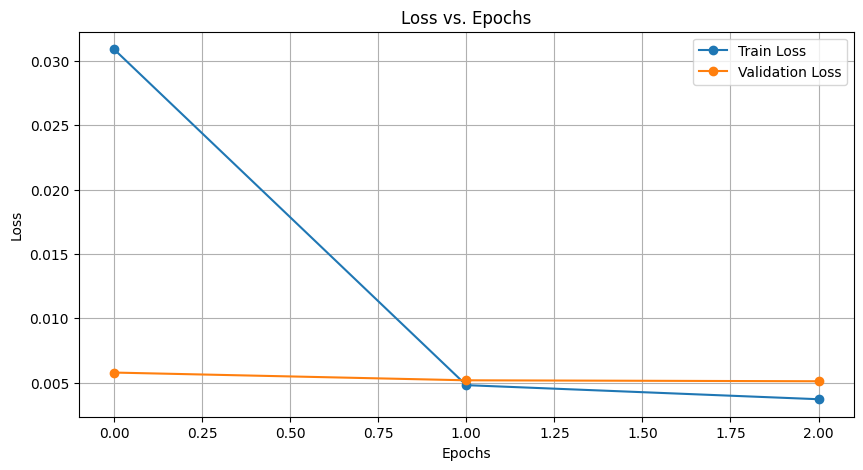

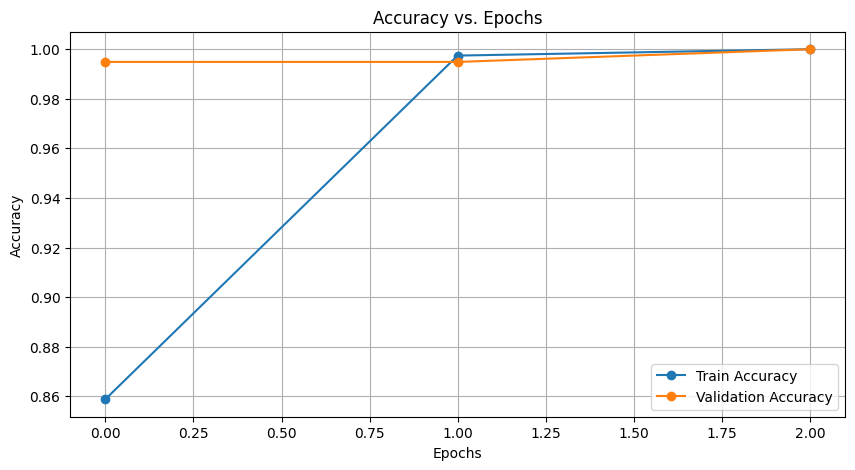

In [21]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="Train Accuracy", marker='o')
plt.plot(val_accs, label="Validation Accuracy", marker='o')
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
